# Gonads - Somatic cells -  palantir analysis

In [1]:
import palantir
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import os
import operator
import matplotlib.pyplot as plt

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_somatic/'
# sc.logging.print_versions()
# sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable
plt.show()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Somatic early

### Read in sanger dataset

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

### Load Niu dataset

In [3]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

## Merge datasets

In [4]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

## Subset cells and import umap

In [5]:
adataGC = sc.read(path_to_gonads + 'mouse-gonads_somatic.h5ad')

In [6]:
adata = adata[[ i in adataGC.obs_names for i in adata.obs_names ]]

In [7]:
adata.obsm['X_umap'] = adataGC.obsm['X_umap']
adata.obsm['X_scVI'] = adataGC.obsm['X_scVI']
adata.obsp['connectivities'] = adataGC.obsp['connectivities']
adata.obsp['distances'] = adataGC.obsp['distances']
adata.uns['celltype_colors'] = adataGC.uns['celltype_colors']
adata.uns['neighbors'] = adataGC.uns['neighbors']

## Filter early somatic cells

In [8]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/palantir/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
adata = adata[[i in ['10.5', '11.5', "E11.5", '12.5', "E12.5"] for i in adata.obs.stage ]]
adata = adata[[i in ['G1'] for i in adata.obs.phase ]]
adata = adata[[i not in [ "cont", 'lowQC', 'CoelEpi_Gata2_cycling', 'OSE', 'Oi', "Ti", "preGC_II", 'granulosa', 'FetalLeydig'] for i in adata.obs.celltype ]]
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
CoelEpi_Gata2,2256,0.188330
CoelEpi_Lhx9,1564,0.130562
Gi,2045,0.170715
Sertoli,1153,0.096252
early_somatic,1409,0.117623
early_supporting,1684,0.140579
preGC_I,1122,0.093664
sPAX8,746,0.062276


In [10]:
sc.pp.filter_genes(adata, min_counts=3)

filtered out 5103 genes that are detected in less than 3 counts


Trying to set attribute `.var` of view, copying.


In [11]:
sc.pp.filter_cells(adata, min_genes=2000)

In [12]:
# clean females in sertoli
mask1 = np.array([i in ['Sertoli'] for i in adata.obs.celltype ])
mask2 = np.array(['female' in i for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata = adata[[not i for i in mask]]
adata.obs['celltype'].value_counts()

CoelEpi_Gata2       2256
Gi                  2045
early_supporting    1684
CoelEpi_Lhx9        1564
early_somatic       1409
Sertoli             1153
preGC_I             1122
sPAX8                746
Name: celltype, dtype: int64

In [13]:
# clean males in preGC_I
mask1 = np.array([i in 'preGC_I' for i in adata.obs['celltype']])
mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata = adata[[not i for i in mask]]
adata.obs['celltype'].value_counts()

CoelEpi_Gata2       2256
Gi                  2045
early_supporting    1684
CoelEpi_Lhx9        1564
early_somatic       1409
Sertoli             1153
preGC_I             1098
sPAX8                746
Name: celltype, dtype: int64

In [14]:
# even male/female pre-supportin
adata.obs['celltype2'] = adata.obs['celltype'].tolist()
mask1 = np.array([i in 'early_supporting' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_supporting_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_supporting_male'

Trying to set attribute `.obs` of view, copying.


In [15]:
# even male/female CoelEpi_LHX9
mask1 = np.array([i in 'CoelEpi_Lhx9' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'CoelEpi_Lhx9_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'CoelEpi_Lhx9_male'
adata.obs['celltype2'].value_counts()

CoelEpi_Gata2              2256
Gi                         2045
early_somatic              1409
Sertoli                    1153
preGC_I                    1098
early_supporting_female    1022
CoelEpi_Lhx9_male           863
sPAX8                       746
CoelEpi_Lhx9_female         701
early_supporting_male       662
Name: celltype2, dtype: int64

In [16]:
# even male/female early_somatic

mask1 = np.array([i in 'early_somatic' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_somatic_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_somatic_male'

In [17]:
# even male/female early_somatic

mask1 = np.array([i in 'sPAX8' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'sPAX8_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'sPAX8_male'

In [18]:
# even male/female early_somatic

mask1 = np.array([i in 'Gi' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'Gi_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'Gi_male'

In [19]:
print(pd.__version__)

1.1.5


... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'sex' as categorical
... storing 'location' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical
... storing 'scmap_fromHuman' as categorical
... storing 'lineage' as categorical
... storing 'celltype2' as categorical
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


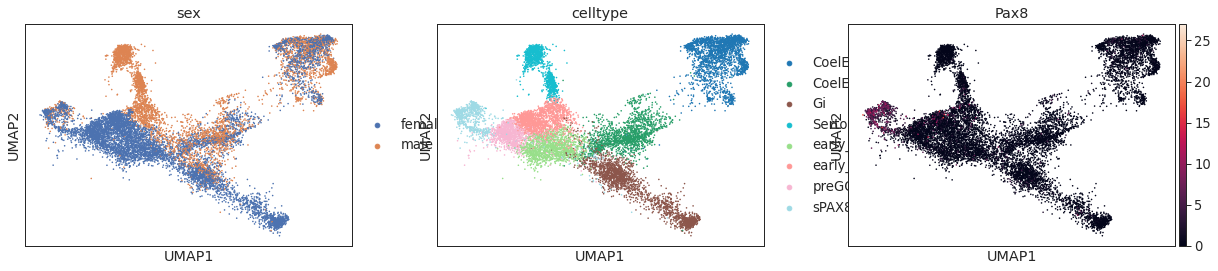

In [20]:
%matplotlib inline
sc.pl.umap(adata, color=['sex', 'celltype', 'Pax8'])

## Downsample

In [21]:
target_cells = 150
half_target_cells = n_obs=target_cells/2

adata.obs['cell'] = adata.obs.index
adata.obs['sex_fake'] = [ '--'+str(i)+'--' for i in adata.obs['celltype2'].tolist() ] # this is ensure perfect match
adata.obs['sex_fake'] = adata.obs['sex_fake'].astype('category')
#adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)

adatas = [adata[adata.obs['sex_fake'].isin([cl])] for cl in adata.obs['sex_fake'].cat.categories]

for dat in adatas:
    celltype = dat.obs.celltype[0]
    if 'early' in celltype or 'sPAX8' in celltype or 'Gi' in celltype or 'CoelEpi_Lhx9' in celltype: # if erly supporting, take half of each sex
        if dat.n_obs > half_target_cells:
            sc.pp.subsample(dat, n_obs=int(half_target_cells), random_state=0)
    else:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])

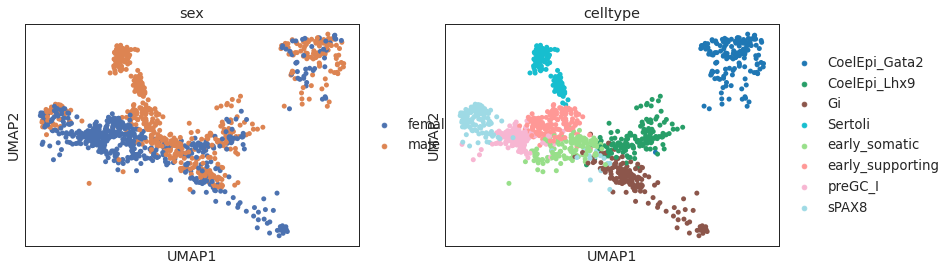

In [22]:
adata = adata[[ i in adata_downsampled.obs.cell.tolist() for i in adata.obs['cell'] ]]
adata
sc.pl.umap(adata, color=['sex', 'celltype'])

In [23]:
# adata.write('trj_palantir1_somatic.h5ad')
adata.obs['celltype2'].value_counts()

preGC_I                    150
Sertoli                    150
CoelEpi_Gata2              150
sPAX8_male                  75
sPAX8_female                75
early_supporting_male       75
early_supporting_female     75
early_somatic_female        75
Gi_male                     75
Gi_female                   75
CoelEpi_Lhx9_male           75
CoelEpi_Lhx9_female         75
early_somatic_male          73
Name: celltype2, dtype: int64

## Find root cell

In [24]:
index, value = max(enumerate(adata[:,'Gata2'].X), key=operator.itemgetter(1))
start_cell = adata.obs.index[index]
start_cell

'HCA_Mou_10828700_CTGCCTAAGACACTAA-Sanger'

Trying to set attribute `.uns` of view, copying.
<ipython-input-25-5499882dabf7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][index] = 1


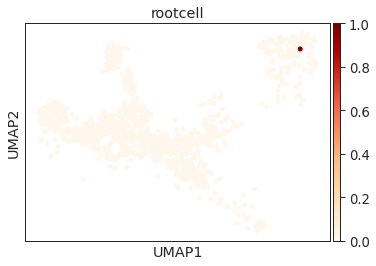

In [25]:
adata.uns['iroot'] = index
adata.obs['rootcell'] = 0
adata.obs['rootcell'][index] = 1

sc.pl.umap(adata,color='rootcell',color_map='OrRd')

In [26]:
start_cell

'HCA_Mou_10828700_CTGCCTAAGACACTAA-Sanger'

## Run diffusion map
Determine the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [27]:
# sc.tl.diffmap(adata)
# sc.tl.dpt(adata, n_branchings=2, n_dcs=15)

## Run palantir

In [28]:
# ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
# pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, knn=30)
# adata.obs['palantir_pseudotime'] = pr_res.pseudotime

## Visualize

In [29]:
# sc.pl.umap(adata, color=['stage',  'sex', 'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1', 'SYCP1', 'FIGLA', 'PIWIL4', 'PIWIL4', 'percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

In [30]:
# sc.pl.diffmap(adata, color=['stage',  'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1','STRA8', 'SYCP1', 'FIGLA', 'PIWIL4','percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

## Gene expression - palantir

#### Generate the norm expression matrix

In [31]:
adata_count = adata.copy()
sc.pp.filter_genes(adata_count, min_counts=3)
sc.pp.filter_cells(adata_count, min_genes=3)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
sc.pp.highly_variable_genes(adata_count, n_top_genes=2000)

m = adata_count.X.toarray()
norm_df = pd.DataFrame(data=m, index=adata_count.obs_names, columns=adata_count.var_names)

filtered out 3655 genes that are detected in less than 3 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=1000
    finished (0:00:49)
computing PCA
    on highly variable genes
    with n_comps=321
    finished (0:00:13)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


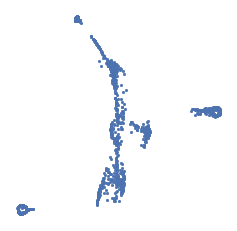

In [32]:
pca_projections, _ = palantir.utils.run_pca(adata_count)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
tsne = palantir.utils.run_tsne(ms_data)
fig, ax = palantir.plot.plot_tsne(tsne)

#### Impute with MAGIC

In [33]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

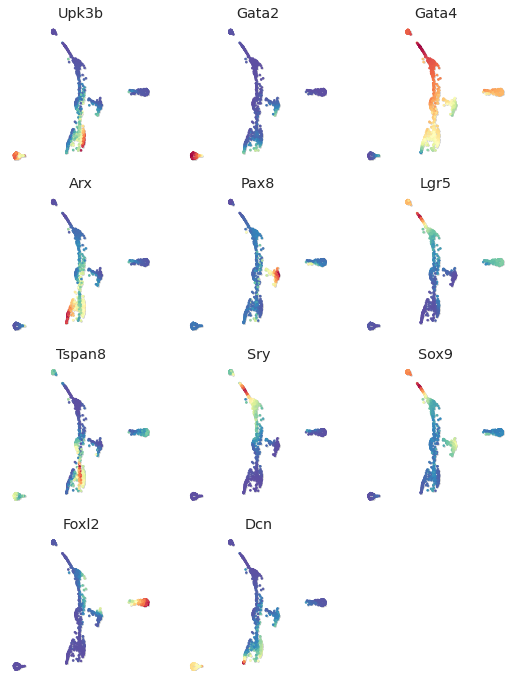

In [34]:
genes = ['Upk3b', 'Gata2', 'Gata4', 'Arx', 'Pax8', 'Lgr5', 'Tspan8', 'Sry', 'Sox9', 'Foxl2', 'Dcn']
palantir.plot.plot_gene_expression(imp_df, tsne, genes, n_cols=3)
fig = plt.gcf()
fig.savefig('plot_gene_expression.pdf', dpi=1200)

#### Run diffusion

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


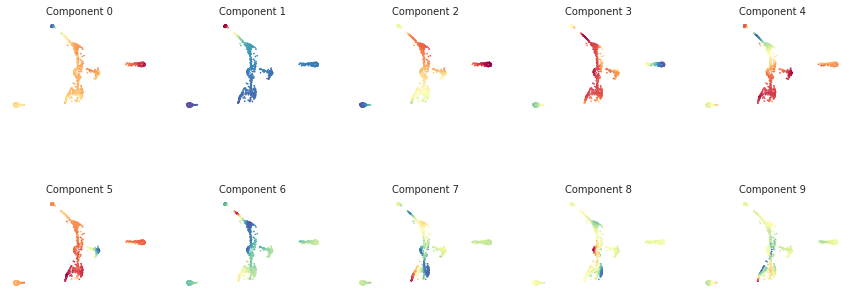

In [35]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

#### Rename terminal states to reflect the known biology below

In [36]:
start_cell

'HCA_Mou_10828700_CTGCCTAAGACACTAA-Sanger'

In [37]:
# obtain pr_res object
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.000829768180847168 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.04961385329564413 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [38]:
pr_res.branch_probs.columns

Index(['HCA_Mou_10827183_TCCCGATTCACGCATA-Sanger',
       'HCA_Mou_10827185_TGCCCATCACCCATGG-Sanger',
       'HCA_Mou_10828699_CATCAAGGTAGCTAAA-Sanger',
       'HCA_Mou_10828699_GTCGGGTGTTACAGAA-Sanger'],
      dtype='object')

In [39]:
# adata.obs['branch_1'] = [i in pr_res.branch_probs.columns[0] for i in adata.obs_names ]
# adata.obs['branch_2'] = [i in pr_res.branch_probs.columns[1] for i in adata.obs_names ]
# sc.pl.umap(adata,color=['branch_1','branch_2'],color_map='OrRd')
# palantir.plot.highlight_cells_on_tsne(tsne, start_cell)
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[0])
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[1])

HCA_Mou_10827183_TCCCGATTCACGCATA-Sanger


<ipython-input-40-be04d9660218>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tarcell'][i] = 1


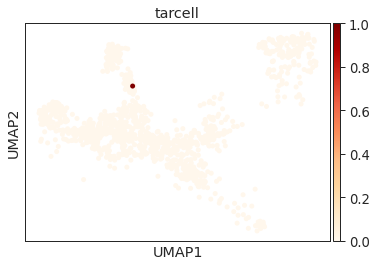

HCA_Mou_10827185_TGCCCATCACCCATGG-Sanger


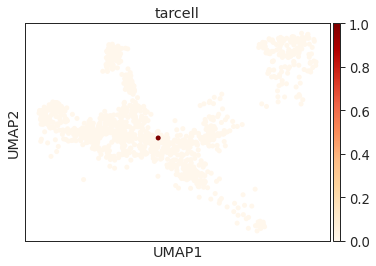

HCA_Mou_10828699_CATCAAGGTAGCTAAA-Sanger


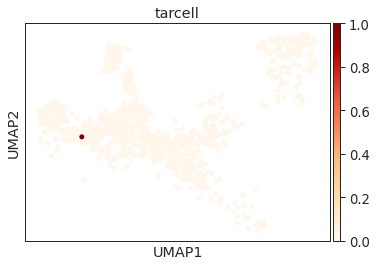

HCA_Mou_10828699_GTCGGGTGTTACAGAA-Sanger


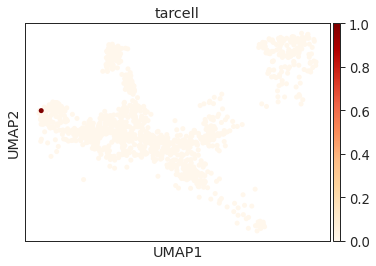

In [40]:
for i in pr_res.branch_probs.columns.tolist():
    print(i)
    adata.obs['tarcell'] = 0
    adata.obs['tarcell'][i] = 1
    sc.pl.umap(adata,color='tarcell',color_map='OrRd')

In [41]:
# mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])
# mapping['oocyte'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
# mapping['pre_spematogonia'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
# #mapping['PGC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
# #mapping['PGC'] = pr_res.branch_probs.columns.difference(mapping.values)
# mapping = pd.Series(mapping.index, index=mapping)
# mapping

In [42]:
# pr_res.branch_probs.columns = mapping
# pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Oocyte', 'Spermatocyte']]
# pr_res.branch_probs.head()

In [43]:
# palantir.plot.plot_palantir_results(pr_res, tsne)
# fig = plt.gcf()
# fig.savefig('figures_somatic/plot_palantir_results.pdf', dpi=1200)

## Gene expression trends

In [44]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

HCA_Mou_10827183_TCCCGATTCACGCATA-Sanger
Time for processing HCA_Mou_10827183_TCCCGATTCACGCATA-Sanger: 0.05032992362976074 minutes
HCA_Mou_10827185_TGCCCATCACCCATGG-Sanger
Time for processing HCA_Mou_10827185_TGCCCATCACCCATGG-Sanger: 0.009023586908976236 minutes
HCA_Mou_10828699_CATCAAGGTAGCTAAA-Sanger
Time for processing HCA_Mou_10828699_CATCAAGGTAGCTAAA-Sanger: 0.009190193812052409 minutes
HCA_Mou_10828699_GTCGGGTGTTACAGAA-Sanger
Time for processing HCA_Mou_10828699_GTCGGGTGTTACAGAA-Sanger: 0.00938568909962972 minutes


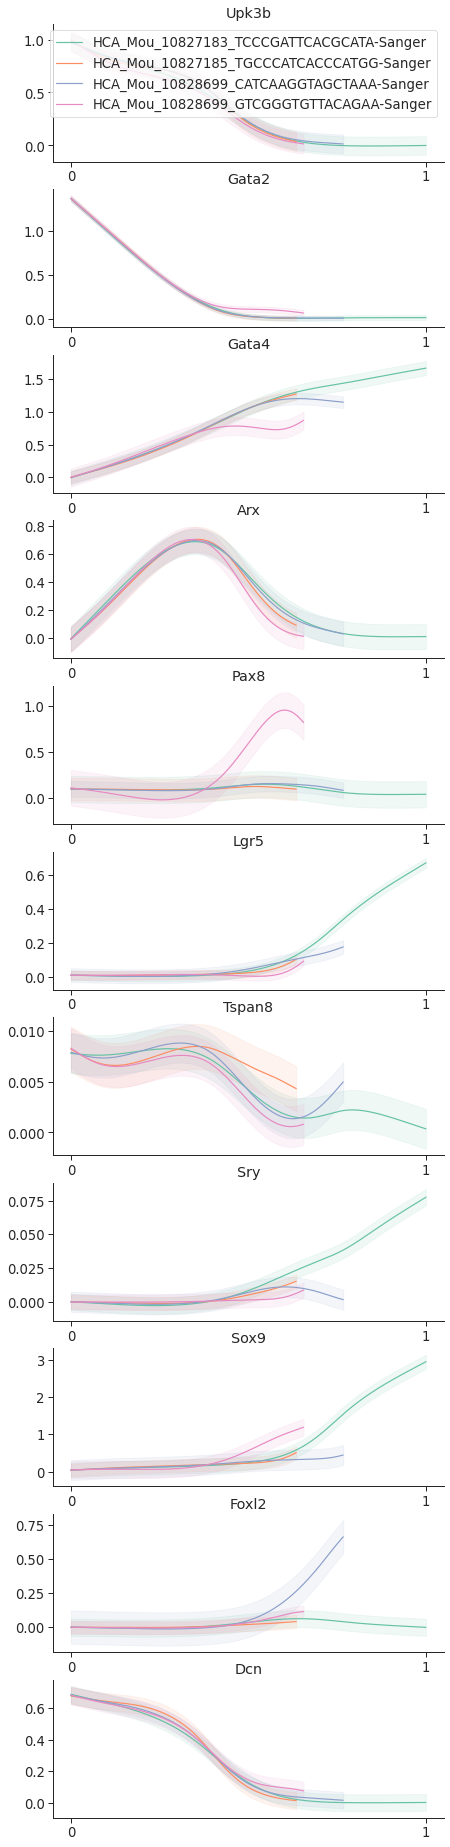

In [45]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

## Run palantir especifing endpoint as well

In [46]:
index, value = max(enumerate(adata[:,'Gata2'].X), key=operator.itemgetter(1))
coelepiGata2 = adata.obs.index[index]
coelepiGata2


index, value = max(enumerate(adata[:,'Sox9'].X), key=operator.itemgetter(1))
sertoli = adata.obs.index[index]
sertoli


index, value = max(enumerate(adata[:,'Foxl2'].X), key=operator.itemgetter(1))
granulosa = adata.obs.index[index]
granulosa


index, value = max(enumerate(adata[:,'Pax8'].X), key=operator.itemgetter(1))
sPAX8 = adata.obs.index[index]
sPAX8


index, value = max(enumerate(adata[:,'Dcn'].X), key=operator.itemgetter(1))
Gi = adata.obs.index[index]
Gi



'HCA_Mou_10828700_CTTACCGCAAAGCAAT-Sanger'

In [47]:
terminal_states = pd.Series(['sertoli', 'granulosa', 'sPAX8', 'Gi'], index=[ sertoli, granulosa, sPAX8, Gi])
pr_res = palantir.core.run_palantir(ms_data, coelepiGata2, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0009221235911051432 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.05513769785563151 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [48]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

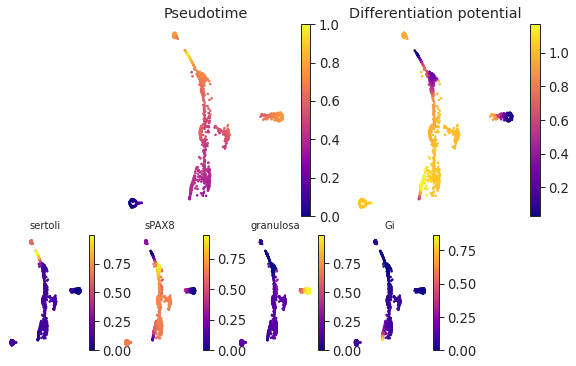

In [49]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_resultsEndpoint.pdf', dpi=1200)

In [50]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

sertoli
Time for processing sertoli: 0.05361415147781372 minutes
sPAX8
Time for processing sPAX8: 0.009199190139770507 minutes
granulosa
Time for processing granulosa: 0.009108253320058187 minutes
Gi
Time for processing Gi: 0.00898895263671875 minutes


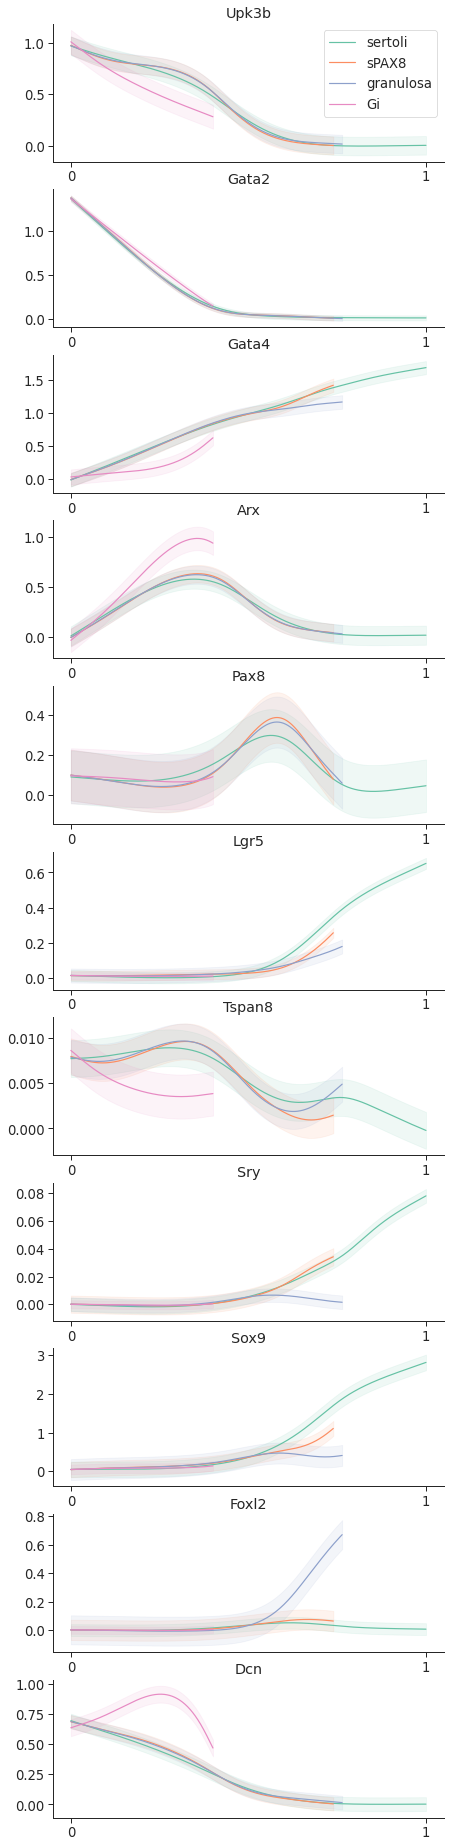

In [51]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

# Clustering

In [52]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
clusters = adata.obs['celltype']

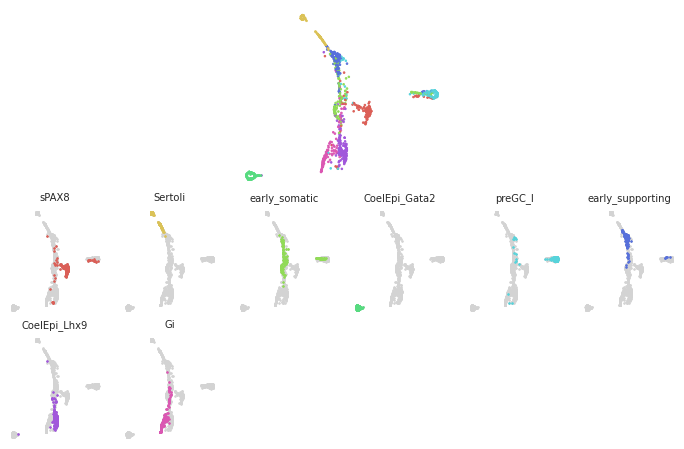

In [53]:
palantir.plot.plot_cell_clusters(tsne, clusters)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_celltypes.pdf', dpi=1200)

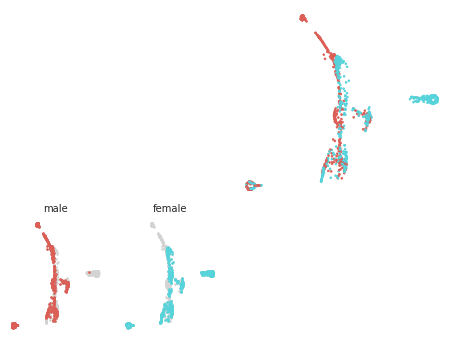

In [54]:
sex = adata.obs['sex']
palantir.plot.plot_cell_clusters(tsne, sex)
fig = plt.gcf()
fig.savefig('figures_somatic/plot_palantir_sex.pdf', dpi=1200)